# Análisis de las señales oblicuas usando inferencia bayesiana

In [79]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import interpolate
import seaborn as sns
sns.set()
import pandas as pd
import pickle

import theano.tensor as TT
import time
import random

import pymc3 as pm
import arviz as az

import sys
#import winsound

In [80]:
%run Bayes3.ipynb
%run Pinel.ipynb
%run R_Fresnel.ipynb

In [81]:
## Parámetros globales de la antena

Fs = 23.328e9 #Frecuencia de muestreo [Hz] 
Ts = 1/Fs
BW = 1.5e9 

corte = 150
Nfft= 1024 # nro de frecs -> conviene que sea multiplo de 2 para calcular la FFT de manera eficiente. 
#Tiene que ser mayor a la longitud de la señal (285 para 2m, 439 para 3m)

portadora = 'Fc8' #input('Fc7 , Fc8')
mediciones = ['06_09','07_15','08_22']
dia = input('dia de medicion? (jun=1, jul=2, ag=3)')
dia = mediciones[int(dia)-1]
print(dia)

if portadora == 'Fc8':
    fc = 8.748e9
    print('fc =',str(fc/1e9) + 'GHz')
    f_pos = np.load('mediciones/f.npy',mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

    if dia == '06_09':
        altura = '1'
        tita = input('titas posibles: 5, 10, 15, 20, 25, 30, 40, 50')
        ep1_obs = (11.496 +1j*4.028) - 1j #2,5cm
        ep2_obs = (13.894 + 1j*5.12) - 1j #7cm
        ep3_obs = (22.823 + 1j*18.73) - 1j #13cm
        
        
    elif dia == '07_15':
        altura = '0'
        tita = input('titas posibles: 10, 20, 30, 40')
        ep1_obs = (8.129 +1j*4.91) -1j #2cm
        ep2_obs = (10.302 + 1j*6.12) -1j #7cm
        ep3_obs = (11.268 + 1j*6.695) -1j#14cm
    
    else:
        altura = '1'
        tita = input('titas posibles: 10, 20')
        ep1_obs = 7.6 + 1j*4.36 #2cm
        ep2_obs = 7.54 + 1j*3.94 #9cm
        ep3_obs = 'error' #no se medio otra humedad
            
    cal = input('calibracion A? y or n')
    if cal == 'n':        
        with open('mediciones/altura_'+altura+'.pkl','rb') as Q:
            med = pickle.load(Q)
        Scal = med.get('S1_'+dia)
        cal = ''

    else:
        with open('mediciones/S1_av.pkl','rb') as T:
            S1_av = pickle.load(T)
        Scal = S1_av.get('S1_av')
        Scal = Scal[int(altura)]
        cal = 'A'

    with open('mediciones/Z2_'+dia+'.pkl','rb') as QQ:
        Z2 = pickle.load(QQ)
    Star = Z2.get('Z2_'+tita)

    theta = np.radians(int(tita))
else:
    fc = 7.290e9
    print('fc =',str(fc/1e9) + 'GHz')
    print('las mediciones para Fc7 no estan procesadas')

print('dim f_pos:',np.shape(f_pos))
print('dim S1:',np.shape(Scal))
print('dim Z2:',np.shape(Star))
print('tita:',tita,'--> radianes:',str(theta)) 

07_15
fc = 8.748GHz
dim f_pos: (153,)
dim S1: (153,)
dim Z2: (153,)
tita: 20 --> radianes: 0.3490658503988659


# Ajustes con el esquema bayesiano:

-------------------
Incidencia en un dielectrico sin rugosidad
-------------------

Datos:
Dia de medicion: 07_15
angulo: 20
Altura: 0


-------------------
Corro bayes
-------------------
Ruido :  0.0225
Muestras :  5000



Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.003
Stage:   1 Beta: 0.007
Stage:   2 Beta: 0.014
Stage:   3 Beta: 0.031
Stage:   4 Beta: 0.068
Stage:   5 Beta: 0.152
Stage:   6 Beta: 0.333
Stage:   7 Beta: 0.737
Stage:   8 Beta: 1.000
Stage:   0 Beta: 0.003
Stage:   1 Beta: 0.007
Stage:   2 Beta: 0.014
Stage:   3 Beta: 0.031
Stage:   4 Beta: 0.069
Stage:   5 Beta: 0.153
Stage:   6 Beta: 0.338
Stage:   7 Beta: 0.745
Stage:   8 Beta: 1.000
Stage:   0 Beta: 0.003
Stage:   1 Beta: 0.007
Stage:   2 Beta: 0.014
Stage:   3 Beta: 0.031
Stage:   4 Beta: 0.068
Stage:   5 Beta: 0.150
Stage:   6 Beta: 0.330
Stage:   7 Beta: 0.727
Stage:   8 Beta: 1.000
Stage:   0 Beta: 0.003
Stage:   1 Beta: 0.007
Stage:   2 Beta: 0.014
Stage:   3 Beta: 0.031
Stage:   4 Beta: 0.067
Stage:   5 Beta: 0.149
Stage:   6 Beta: 0.331
Stage:   7 Beta: 0.730
Stage:   8 Beta: 1.000
Stage:   0 Beta: 0.003
Stage:   1 Beta: 0.007
Stage:   2 Beta: 0.014
Stage:   3 Beta: 0.031
Stage:   4 Beta: 0.069
S

Tiempo insumido - Inf. Bayesiana: 46.44 seg (0.77 min)
Graficando con un solo dielectrico ...

input ep1_r:  8.129
output ep1_r:  4.024 +/- 0.022

input ep1_i:  3.91
output ep1_i:  3.011 +/- 0.011

Tiempo insumido - Graficos: 1.27 seg (0.02 min)

Tiempo insumido - TOTAL: 47.7 seg (0.8 min)



Altura: 0


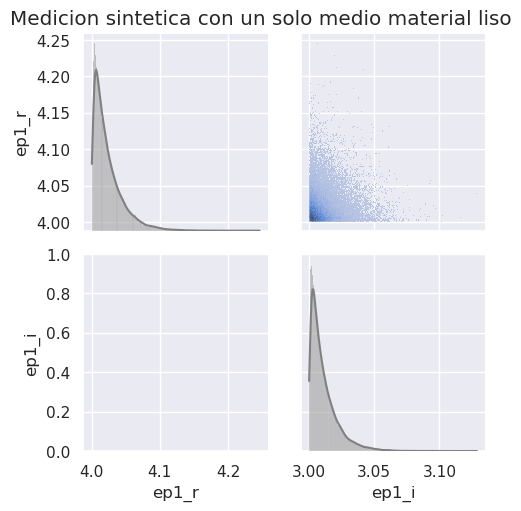

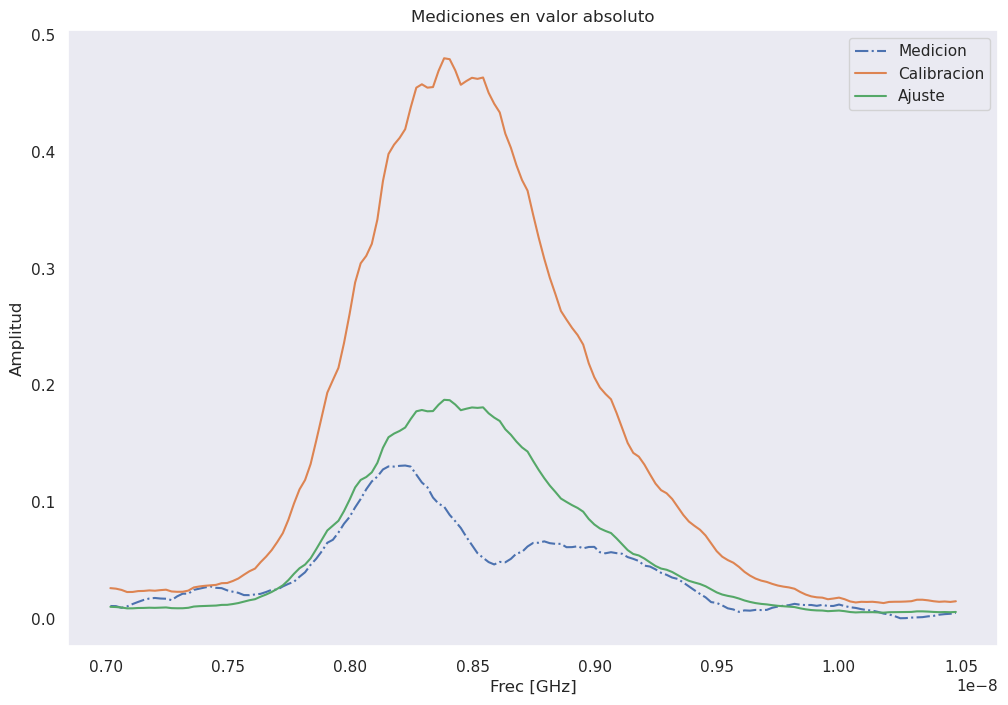

In [82]:
# %%capture cap --no-stderr
NLayers = 1
print('-------------------')
print('Incidencia en un dielectrico sin rugosidad')
print('-------------------')
print()
print('Datos:')
print('Dia de medicion:', dia)
print('angulo:', tita)
print('Altura:', altura)
name = 'lisa_'+dia+cal+'-T'+tita
print()
print()
print('-------------------')
print('Corro bayes')
print('-------------------')

t0 = time.time()
# nro de muestras que va a utilizar el método
noise_level = 2.25e-2
print('Ruido : ',noise_level)
muestras = 5000
print('Muestras : ',muestras)
# error de la medición
sigmas = noise_level*np.ones((1,len(Star)))
print()


# inferencia bayesiana
traza_sim_1layer = modelo(Star,theta,muestras,sigmas,NLayers,False)
t1 = time.time()
print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)')


t2 = time.time()
print('Graficando con un solo dielectrico ...')

ep1_r_mean = round(np.mean(traza_sim_1layer['ep1_r']),3)
ep1_r_std = round(np.std(traza_sim_1layer['ep1_r']),3)

ep1_i_mean = round(np.mean(traza_sim_1layer['ep1_i']),3)
ep1_i_std = round(np.std(traza_sim_1layer['ep1_i']),3)

plotear = np.stack((traza_sim_1layer['ep1_r'], traza_sim_1layer['ep1_i'])).T 
dfplotear = pd.DataFrame(plotear, columns = ['ep1_r', 'ep1_i'])


g = sns.PairGrid(dfplotear)
g.fig.suptitle('Medicion sintetica con un solo medio material liso', y=1.01, fontsize = 'large')
g.map_upper(sns.histplot)
# g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True, color='.5')
# g.axes[0,0].axvline(np.real(ep1_obs), color='r', linestyle='solid', linewidth=0.5)
# g.axes[1,0].scatter(np.real(ep1_obs), np.imag(ep1_obs), marker="+", c='r', s=200)
# g.axes[1,1].axvline(np.imag(ep1_obs), color='r', linestyle='solid', linewidth=0.5)
g.savefig('outputs/Z2/1capa/bayes-'+name+'.png')

print()
print('input ep1_r: ', np.real(ep1_obs))
print('output ep1_r: ', str(ep1_r_mean)+" +/- "+str(ep1_r_std))
print()
print('input ep1_i: ', round(np.imag(ep1_obs),3))
print('output ep1_i: ', str(ep1_i_mean)+" +/- "+str(ep1_i_std))
print()

t3 = time.time()
print('Tiempo insumido - Graficos: '+str(round(t3-t2,2))+' seg', '('+str(round((t3-t2)/60,2))+' min)')
print()

print('Tiempo insumido - TOTAL: '+str(round(t3-t0,2))+' seg', '('+str(round((t3-t0)/60,2))+' min)')
print()
print()
print()

#-----------------------------
EP1 = ep1_r_mean + 1j*ep1_i_mean
S_fit = Scal*RR_ep(EP1,theta)

plt.figure(figsize=(12,8))
plt.plot(f_pos/1e9,np.abs(Star),'-.',label="Medicion")
plt.plot(f_pos/1e9,np.abs(Scal),label="Calibracion")
plt.plot(f_pos/1e9,np.abs(S_fit),label="Ajuste")
plt.grid()
plt.xlabel('Frec [GHz]')
plt.ylabel('Amplitud')
plt.title('Mediciones en valor absoluto')
plt.legend(loc="best")
plt.savefig('outputs/Z2/1capa/fig-'+name+'.png')

#----------------------------------

with open('outputs/Z2/1capa/'+name+'.txt', 'w') as f:
    print('-------------------', file=f)
    print('Incidencia en un dielectrico sin rugosidad', file=f)
    print('-------------------', file=f)
    print('', file=f)
    print('Datos:', file=f)
    print('Dia de medicion:', dia, file=f)
    print('angulo:', tita, file=f)
    print('Altura:', altura)
    print('', file=f)
    print('', file=f)
    print('-------------------', file=f)
    print('Corro bayes', file=f)
    print('-------------------', file=f)
    print('Ruido : ',noise_level, file=f)
    print('Muestras : ',muestras, file=f)
    print('', file=f)
    print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)', file=f)
    print('', file=f)
    print('Graficando con un solo dielectrico ...', file=f)
    print('input ep1_r: ', np.real(ep1_obs), file=f)
    print('output ep1_r: ', str(ep1_r_mean)+" +/- "+str(ep1_r_std), file=f)
    print('', file=f)
    print('input ep1_i: ', round(np.imag(ep1_obs),3), file=f)
    print('output ep1_i: ', str(ep1_i_mean)+" +/- "+str(ep1_i_std), file=f)
    print('', file=f)
    print('Tiempo insumido - Graficos: '+str(round(t3-t2,2))+' seg', '('+str(round((t3-t2)/60,2))+' min)', file=f)
    print('Tiempo insumido - TOTAL: '+str(round(t3-t0,2))+' seg', '('+str(round((t3-t0)/60,2))+' min)', file=f)
    print('', file=f)
    print('', file=f)
f.close()


# - Dos dieléctricos

In [83]:
NLayers = 2
if dia == '06_09':
    # junio
    d_obs = 0.13

elif dia == '07_15':
    # julio
    d_obs = 0.14

else:
    # agosto
    d_obs = 0.09

## Sin rugosidad

-------------------
Incidencia en un dielectrico con 2 capas sin rugosidad
-------------------

Datos:
Dia de medicion: 07_15
angulo: 20
Altura: 0


-------------------
Corro bayes
-------------------
Ruido :  0.0225
Muestras :  5000



Initializing SMC sampler...
Sampling 6 chains in 6 jobs
/home/gordotony/anaconda3/envs/UWB/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.006
Stage:   1 Beta: 0.018
Stage:   2 Beta: 0.055
Stage:   3 Beta: 0.178
Stage:   4 Beta: 0.598
Stage:   5 Beta: 1.000
Stage:   0 Beta: 0.006
Stage:   1 Beta: 0.018
Stage:   2 Beta: 0.053
Stage:   3 Beta: 0.172
Stage:   4 Beta: 0.568
Stage:   5 Beta: 1.000
Stage:   0 Beta: 0.006
Stage:   1 Beta: 0.018
Stage:   2 Beta: 0.054
Stage:   3 Beta: 0.182
Stage:   4 Beta: 0.601
Stage:   5 Beta: 1.000
Stage:   0 Beta: 0.006
Stage:   1 Beta: 0.018
Stage:   2 Beta: 0.055
Stage:   3 Beta: 0.181
Stage:   4 Beta: 0.608
Stage:   5 Beta: 1.000
Stage:   0 Beta: 0.006
Stage:   1 Beta: 0.018
Stage:   2 Beta: 0.054
Stage:   3 Beta: 0.175
Stage:   4 Beta: 0.577
Stage:

Tiempo insumido - Inf. Bayesiana: 151.29 seg (2.52 min)
Graficando para 2 layers ...


input ep1_r:  8.129
output ep1_r:  9.039 +/- 2.67

input ep1_i:  3.91
output ep1_i:  6.009 +/- 1.153

input ep2_r:  10.302
output ep2_r:  13.522 +/- 0.021

input ep2_i:  5.12
output ep2_i:  8.518 +/- 1.442

input d:  0.14
output d:  0.005 +/- 0.003

Tiempo insumido - Graficos: 4.7 seg (0.08 min)

Tiempo insumido - TOTAL: 155.99 seg (2.6 min)





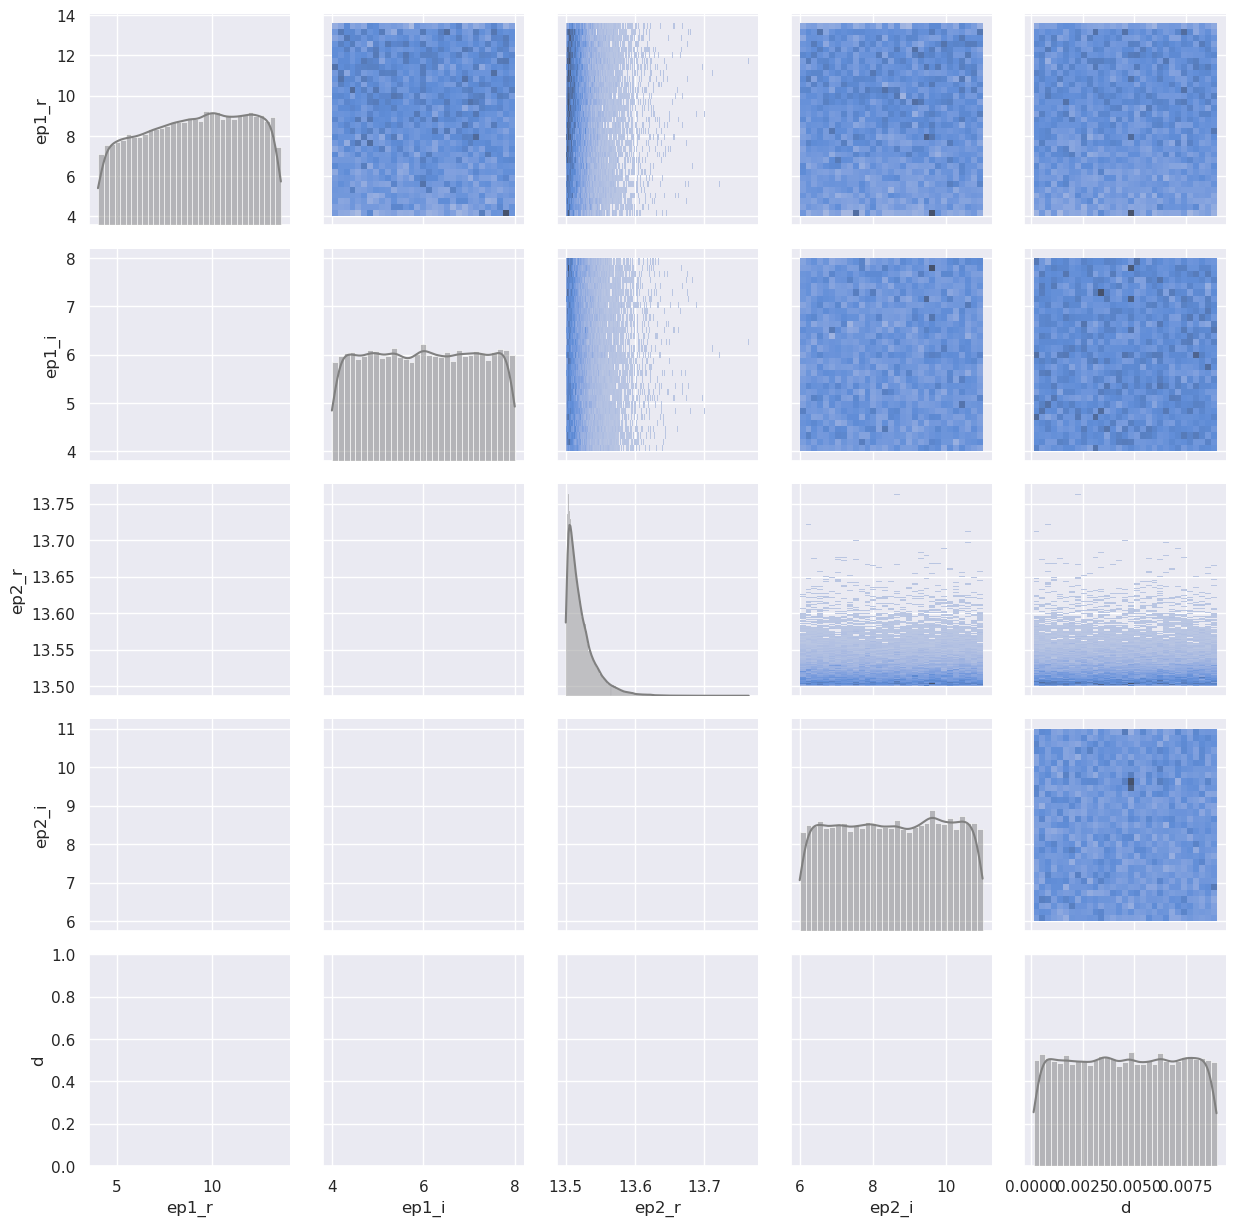

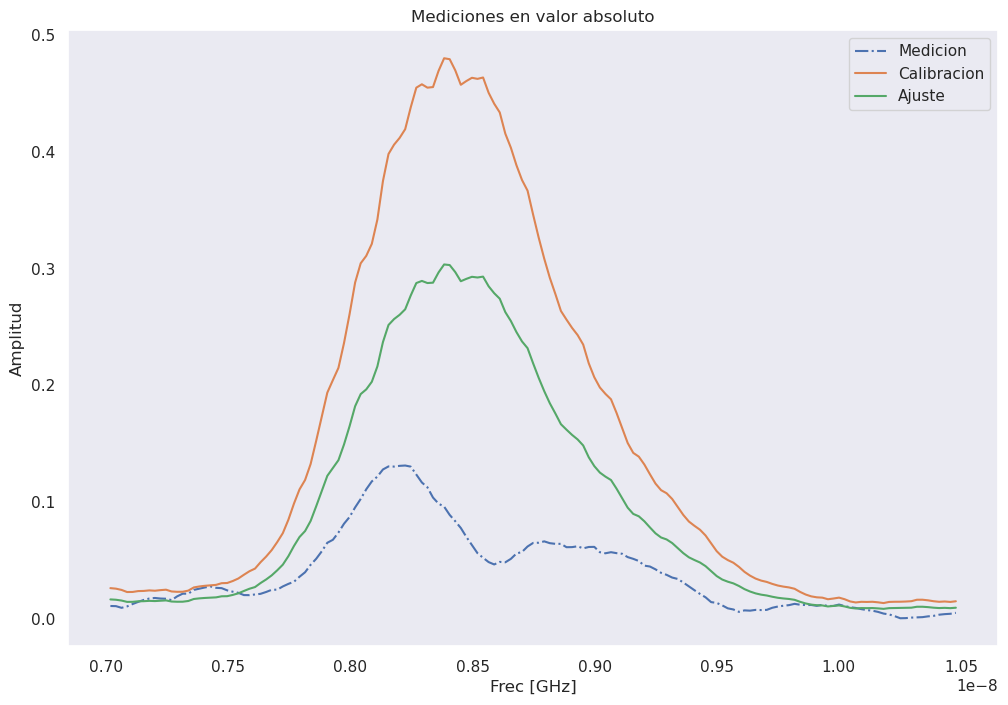

In [84]:
print('-------------------')
print('Incidencia en un dielectrico con 2 capas sin rugosidad')
print('-------------------')
print()
print('Datos:')
print('Dia de medicion:', dia)
print('angulo:', tita)
print('Altura:', altura)
name = 'lisa_'+dia+cal+'-T'+tita
print()
print()
print('-------------------')
print('Corro bayes')
print('-------------------')
t0 = time.time()

# nro de muestras que va a utilizar el método
muestras = 5000
noise_level = 2.25e-2
# error de la medición
sigmas = noise_level*np.ones((1,len(Star)))

print('Ruido : ',noise_level)
print('Muestras : ',muestras)
print()

# inferencia bayesiana
traza_sim_2layers = modelo(Star,theta,muestras,sigmas,NLayers,rug=False)

t1 = time.time()
print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)')

#Ploteo
t2 = time.time()
print('Graficando para 2 layers ...')
print()

ep1_r_mean = round(np.mean(traza_sim_2layers['ep1_r']),3)
ep1_r_std = round(np.std(traza_sim_2layers['ep1_r']),3)

ep1_i_mean = round(np.mean(traza_sim_2layers['ep1_i']),3)
ep1_i_std = round(np.std(traza_sim_2layers['ep1_i']),3)

ep2_r_mean = round(np.mean(traza_sim_2layers['ep2_r']),3)
ep2_r_std = round(np.std(traza_sim_2layers['ep2_r']),3)

ep2_i_mean = round(np.mean(traza_sim_2layers['ep2_i']),3)
ep2_i_std = round(np.std(traza_sim_2layers['ep2_i']),3)

d_mean = round(np.mean(traza_sim_2layers['d']),3)
d_std = round(np.std(traza_sim_2layers['d']),3)


plotear = np.stack((traza_sim_2layers['ep1_r'], traza_sim_2layers['ep1_i'], traza_sim_2layers['ep2_r'], 
                    traza_sim_2layers['ep2_i'], traza_sim_2layers['d'])).T 
dfplotear = pd.DataFrame(plotear, columns = ['ep1_r','ep1_i','ep2_r','ep2_i','d'])

g = sns.PairGrid(dfplotear)
# g.fig.suptitle(zonaMed, y=1.01, fontsize = 'xx-large')
g.map_upper(sns.histplot)
#g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True, color='.5')
g.savefig('outputs/Z2/2capas/bayes-'+name+'.png')

print()
print('input ep1_r: ', np.real(ep1_obs))
print('output ep1_r: ', str(ep1_r_mean)+" +/- "+str(ep1_r_std))
print()
print('input ep1_i: ', np.imag(ep1_obs))
print('output ep1_i: ', str(ep1_i_mean)+" +/- "+str(ep1_i_std))
print()
print('input ep2_r: ', np.real(ep2_obs))
print('output ep2_r: ', str(ep2_r_mean)+" +/- "+str(ep2_r_std))
print()
print('input ep2_i: ', np.imag(ep2_obs))
print('output ep2_i: ', str(ep2_i_mean)+" +/- "+str(ep2_i_std))
print()
print('input d: ', d_obs)
print('output d: ', str(d_mean)+" +/- "+str(d_std))
print()

t3 = time.time()
print('Tiempo insumido - Graficos: '+str(round(t3-t2,2))+' seg', '('+str(round((t3-t2)/60,2))+' min)')
print()

print('Tiempo insumido - TOTAL: '+str(round(t3-t0,2))+' seg', '('+str(round((t3-t0)/60,2))+' min)')
print()
print()
print()

#---------------------------------------------
EP1 = ep1_r_mean + 1j*ep1_i_mean
EP2 = ep2_r_mean + 1j*ep2_i_mean
Dis = d_mean

S_fit = Scal*RR_ep1_ep2(EP1,EP2,theta,Dis,f_pos)

plt.figure(figsize=(12,8))
plt.plot(f_pos/1e9,np.abs(Star),'-.',label="Medicion")
plt.plot(f_pos/1e9,np.abs(Scal),label="Calibracion")
plt.plot(f_pos/1e9,np.abs(S_fit),label="Ajuste")
plt.grid()
plt.xlabel('Frec [GHz]')
plt.ylabel('Amplitud')
plt.title('Mediciones en valor absoluto')
plt.legend(loc="best")
plt.savefig('outputs/Z2/2capas/fig-'+name+'.png')
#----------------------------------------------

with open('outputs/Z2/2capas/'+name+'.txt', 'w') as f:
    print('-------------------', file=f)
    print('Incidencia en un dielectrico con 2 capas sin rugosidad', file=f)
    print('-------------------', file=f)
    print('Datos:', file=f)
    print('Dia de medicion:', dia, file=f)
    print('angulo:', tita, file=f)
    print('Altura:', altura, file=f)
    print('', file=f)
    print('', file=f)

    print('-------------------', file=f)
    print('Corro bayes', file=f)
    print('-------------------', file=f)
    print('Ruido : ',noise_level, file=f)
    print('Muestras : ',muestras, file=f)
    print('', file=f)
    print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)', file=f)
    print('', file=f)

    print('Graficando con un solo dielectrico ...', file=f)
    print('input ep1_r: ', np.real(ep1_obs), file=f)
    print('output ep1_r: ', str(ep1_r_mean)+" +/- "+str(ep1_r_std), file=f)
    print('', file=f)
    print('input ep1_i: ', round(np.imag(ep1_obs)),3, file=f)
    print('output ep1_i: ', str(ep1_i_mean)+" +/- "+str(ep1_i_std), file=f)
    print('', file=f)
    print('input ep2_r: ', np.real(ep2_obs), file=f)
    print('output ep2_r: ', str(ep2_r_mean)+" +/- "+str(ep2_r_std), file=f)
    print('', file=f)
    print('input ep2_i: ', np.imag(ep2_obs), file=f)
    print('output ep2_i: ', str(ep2_i_mean)+" +/- "+str(ep2_i_std), file=f)
    print('', file=f)
    print('input d: ', d_obs, file=f)
    print('output d: ', str(d_mean)+" +/- "+str(d_std), file=f)
    print('', file=f)
    print('Tiempo insumido - Graficos: '+str(round(t3-t2,2))+' seg', '('+str(round((t3-t2)/60,2))+' min)', file=f)
    print('Tiempo insumido - TOTAL: '+str(round(t3-t0,2))+' seg', '('+str(round((t3-t0)/60,2))+' min)', file=f)
    print('', file=f)
    print('', file=f)
f.close()

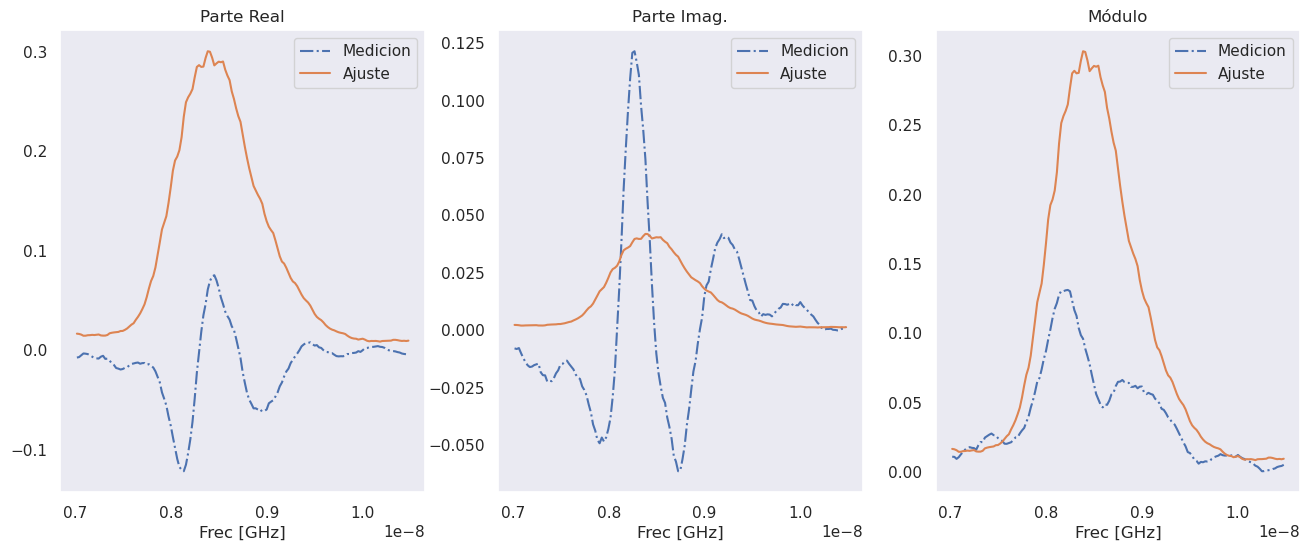

In [85]:
fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))

ax[0].plot(f_pos/1e9,np.real(Star),'-.',label="Medicion")
ax[0].plot(f_pos/1e9,np.real(S_fit),label="Ajuste")
ax[0].grid()
ax[0].set_xlabel('Frec [GHz]')
ax[0].set_title('Parte Real')
ax[0].legend(loc="best")

ax[1].plot(f_pos/1e9,np.imag(Star),'-.',label="Medicion")
ax[1].plot(f_pos/1e9,np.imag(S_fit),label="Ajuste")
ax[1].grid()
ax[1].set_xlabel('Frec [GHz]')
ax[1].set_title('Parte Imag.')
ax[1].legend(loc="best")

ax[2].plot(f_pos/1e9,np.abs(Star),'-.',label="Medicion")
ax[2].plot(f_pos/1e9,np.abs(S_fit),label="Ajuste")
ax[2].grid()
ax[2].set_xlabel('Frec [GHz]')
ax[2].set_title('Módulo')
ax[2].legend(loc="best")
plt.show()

## Con rugosidad

-------------------
Incidencia en un dielectrico con 2 capas con rugosidad
-------------------

Datos:
Dia de medicion: 07_15
angulo: 20
Altura: 0

-------------------
Corro bayes
-------------------
Ruido :  0.025
Muestras :  5000



Initializing SMC sampler...
Sampling 6 chains in 6 jobs
/home/gordotony/anaconda3/envs/UWB/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.010
Stage:   2 Beta: 0.030
Stage:   3 Beta: 0.079
Stage:   4 Beta: 0.194
Stage:   5 Beta: 0.443
Stage:   6 Beta: 0.942
Stage:   7 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.010
Stage:   2 Beta: 0.029
Stage:   3 Beta: 0.077
Stage:   4 Beta: 0.194
Stage:   5 Beta: 0.444
Stage:   6 Beta: 0.944
Stage:   7 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.010
Stage:   2 Beta: 0.030
Stage:   3 Beta: 0.080
Stage:   4 Beta: 0.197
Stage:   5 Beta: 0.451
Stage:   6 Beta: 0.970
Stage:   7 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.010
Stage:   2 Beta: 0.030
Stage:   3 Beta: 0.079
Stage:   4 Beta: 0.190
Stage:

Tiempo insumido - Inf. Bayesiana: 272.29 seg (4.54 min)
Graficando para dos dieléctricos + rugosidad (esto puede demorar...)


input ep1_r:  8.129
output ep1_r:  17.902 +/- 0.684

input ep1_i:  3.91
output ep1_i:  3.994 +/- 1.149

input ep2_r:  10.302
output ep2_r:  18.783 +/- 0.031

input ep2_i:  5.12
output ep2_i:  5.49 +/- 1.446

input d:  0.14
output d:  0.029 +/- 0.015

input s1: ---
output s1:  0.00135 +/- 0.000467

input s2: ---
output s2:  0.00068 +/- 0.000469

Tiempo insumido - Graficos: 287.47 seg (4.79 min)

Tiempo insumido - TOTAL: 279.9 seg (4.67 min)





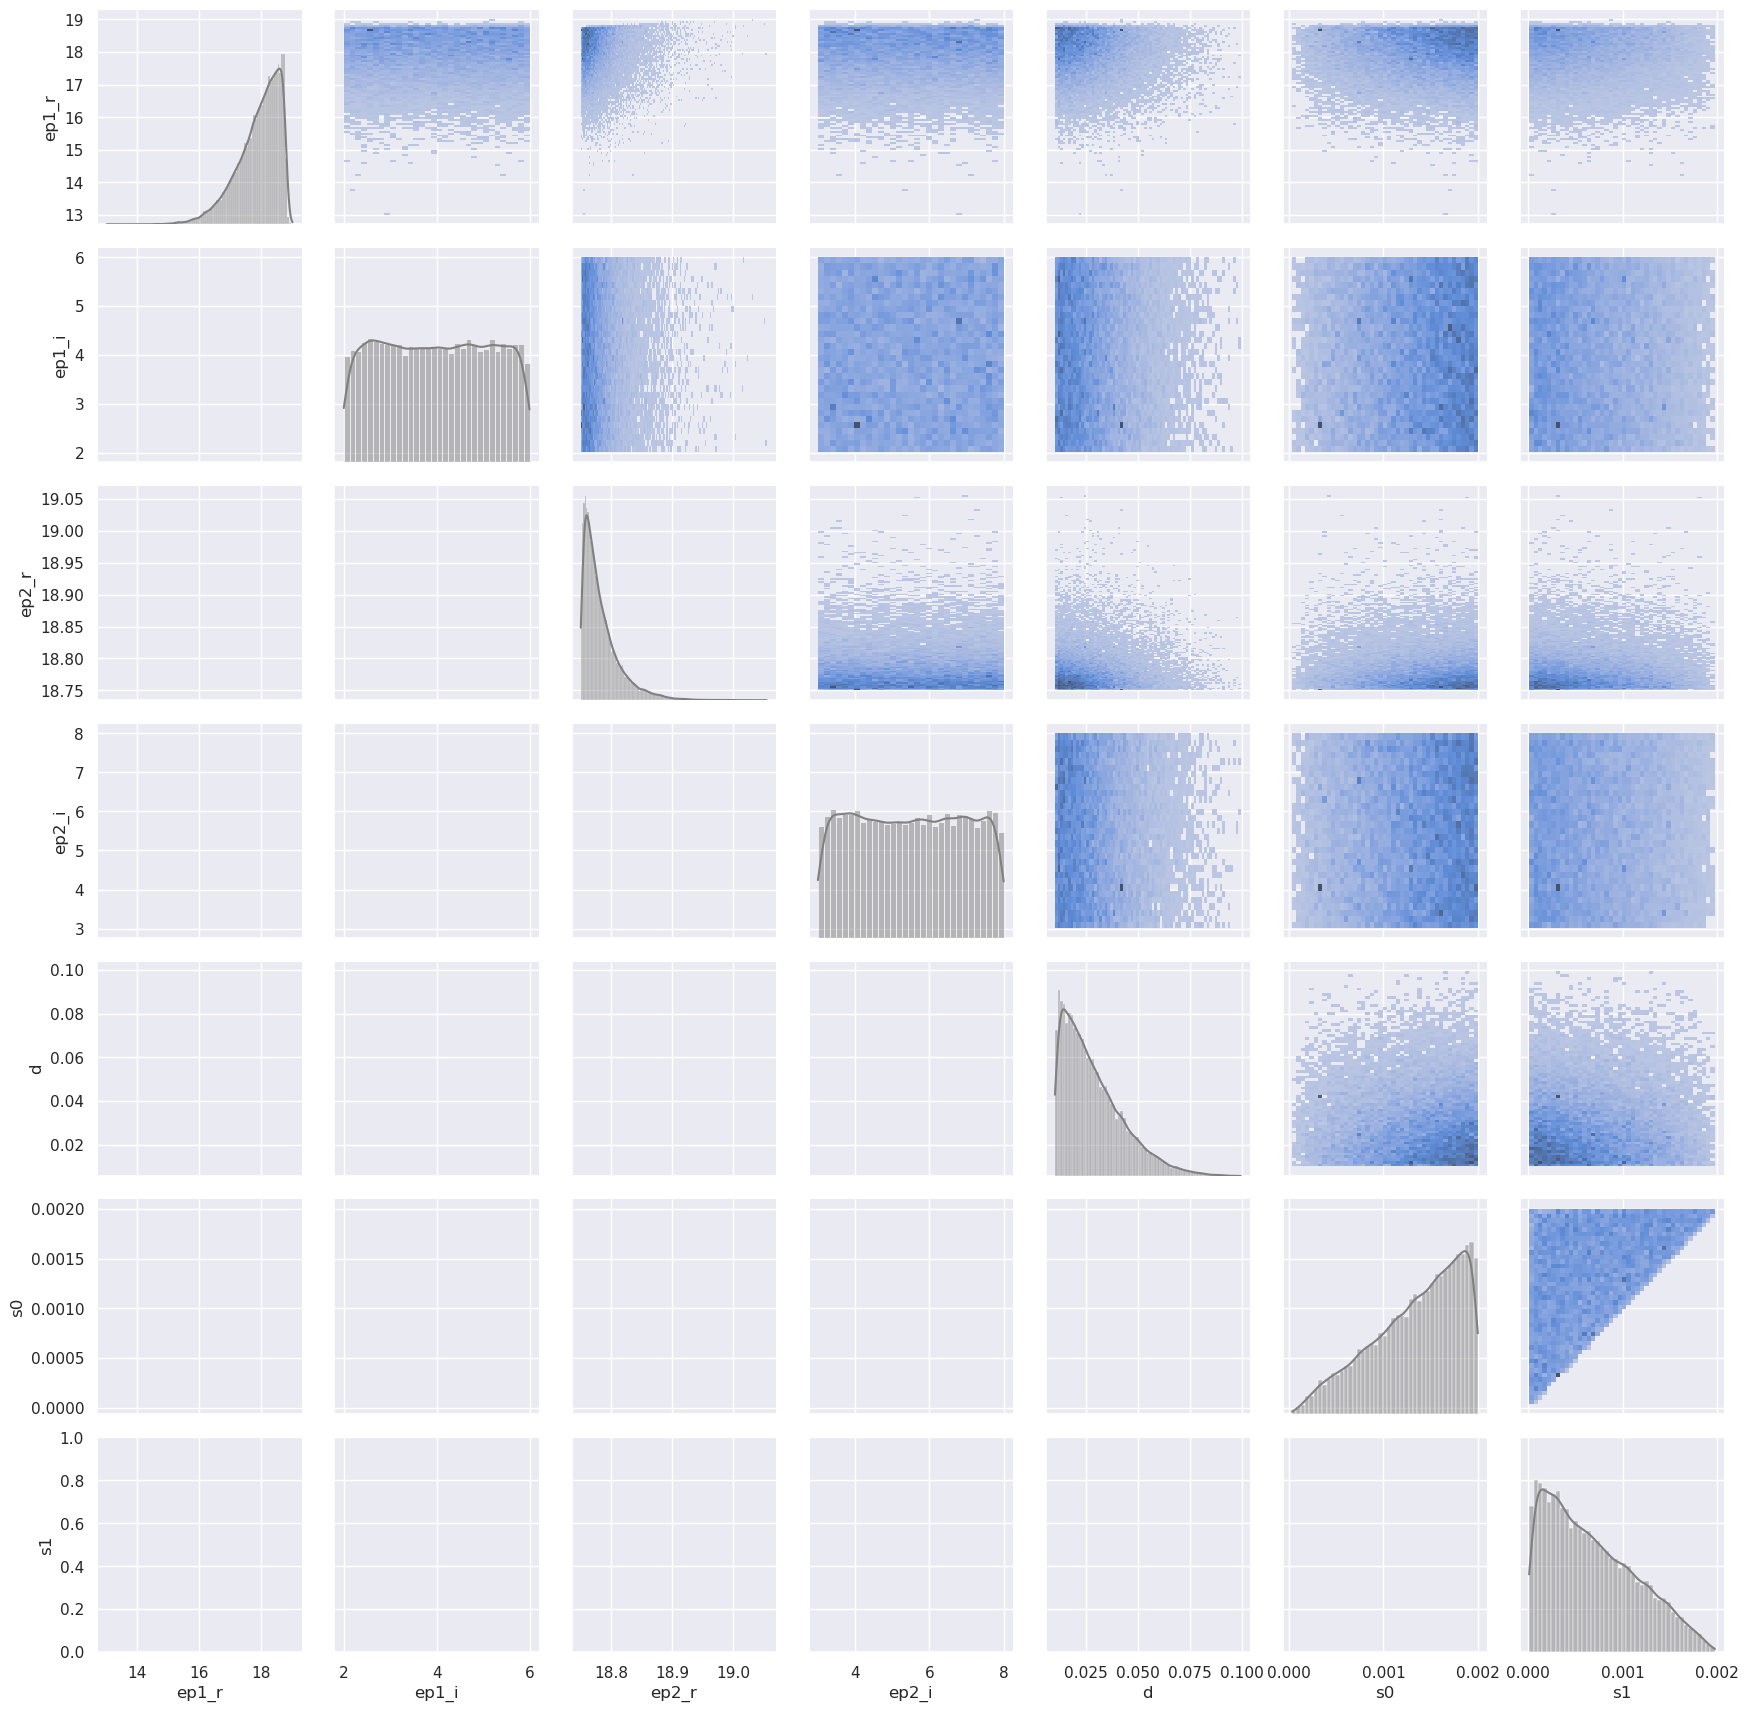

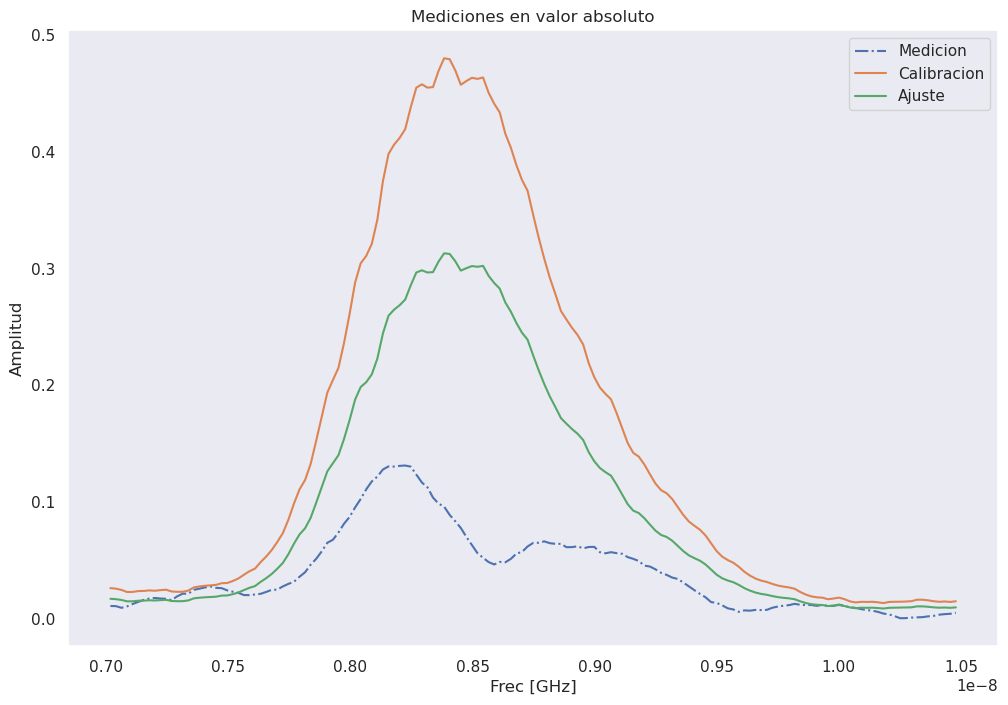

In [86]:
print('-------------------')
print('Incidencia en un dielectrico con 2 capas con rugosidad')
print('-------------------')
print()
print('Datos:')
print('Dia de medicion:', dia)
print('angulo:', tita)
print('Altura:', altura)
name = 'rug_'+dia+cal+'-T'+tita
print()
t0 = time.time()


print('-------------------')
print('Corro bayes')
print('-------------------')
# nro de muestras que va a utilizar el método
muestras = 5000
noise_level = 2.5e-2
# error de la medición
sigmas = noise_level*np.ones((1,len(Star)))
print('Ruido : ',noise_level)
print('Muestras : ',muestras)
print()


# inferencia bayesiana
traza_sim_2layers = modelo(Star,theta,muestras,sigmas,NLayers,True)

t1 = time.time()
print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)')


#Ploteo
print('Graficando para dos dieléctricos + rugosidad (esto puede demorar...)')
print()

ep1_r_mean = round(np.mean(traza_sim_2layers['ep1_r']),3)
ep1_r_std = round(np.std(traza_sim_2layers['ep1_r']),3)

ep1_i_mean = round(np.mean(traza_sim_2layers['ep1_i']),3)
ep1_i_std = round(np.std(traza_sim_2layers['ep1_i']),3)

ep2_r_mean = round(np.mean(traza_sim_2layers['ep2_r']),3)
ep2_r_std = round(np.std(traza_sim_2layers['ep2_r']),3)

ep2_i_mean = round(np.mean(traza_sim_2layers['ep2_i']),3)
ep2_i_std = round(np.std(traza_sim_2layers['ep2_i']),3)

d_mean = round(np.mean(traza_sim_2layers['d']),3)
d_std = round(np.std(traza_sim_2layers['d']),3)

s1_mean = round(np.mean(traza_sim_2layers['s0']),5)
s1_std = round(np.std(traza_sim_2layers['s0']),6)

s2_mean = round(np.mean(traza_sim_2layers['s1']),5)
s2_std = round(np.std(traza_sim_2layers['s1']),6)



plotear = np.stack((traza_sim_2layers['ep1_r'], traza_sim_2layers['ep1_i'], traza_sim_2layers['ep2_r'], 
                    traza_sim_2layers['ep2_i'], traza_sim_2layers['d'],traza_sim_2layers['s0'],traza_sim_2layers['s1'])).T 
dfplotear = pd.DataFrame(plotear, columns = ['ep1_r','ep1_i','ep2_r','ep2_i','d','s0','s1'])

g = sns.PairGrid(dfplotear)
# g.fig.suptitle(zonaMed, y=1.01, fontsize = 'xx-large')
g.map_upper(sns.histplot)
# g.map_lower(sns.histplot)
# g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True, color='.5')
g.savefig('outputs/Z2/2capas/bayes-'+name+'.png')

print()
print('input ep1_r: ', np.real(ep1_obs))
print('output ep1_r: ', str(ep1_r_mean)+" +/- "+str(ep1_r_std))
print()
print('input ep1_i: ', np.imag(ep1_obs))
print('output ep1_i: ', str(ep1_i_mean)+" +/- "+str(ep1_i_std))
print()
print('input ep2_r: ', np.real(ep2_obs))
print('output ep2_r: ', str(ep2_r_mean)+" +/- "+str(ep2_r_std))
print()
print('input ep2_i: ', np.imag(ep2_obs))
print('output ep2_i: ', str(ep2_i_mean)+" +/- "+str(ep2_i_std))
print()
print('input d: ', d_obs)
print('output d: ', str(d_mean)+" +/- "+str(d_std))
print()
print('input s1: ---')
print('output s1: ', str(s1_mean)+" +/- "+str(s1_std))
print()
print('input s2: ---')
print('output s2: ', str(s2_mean)+" +/- "+str(s2_std))
print()

t3 = time.time()
print('Tiempo insumido - Graficos: '+str(round(t3-t2,2))+' seg', '('+str(round((t3-t2)/60,2))+' min)')
print()

print('Tiempo insumido - TOTAL: '+str(round(t3-t0,2))+' seg', '('+str(round((t3-t0)/60,2))+' min)')
print()
print()
print()

EP1 = ep1_r_mean + 1j*ep1_i_mean
EP2 = ep2_r_mean + 1j*ep2_i_mean
Dist = d_mean
S1_opt = s1_mean
S2_opt = s2_mean

S_fit = Scal*Rf_2(EP1,EP2,theta,Dist,S1_opt,S2_opt,f_pos) # señal 'medida'

plt.figure(figsize=(12,8))
plt.plot(f_pos/1e9,np.abs(Star),'-.',label="Medicion")
plt.plot(f_pos/1e9,np.abs(Scal),label="Calibracion")
plt.plot(f_pos/1e9,np.abs(S_fit),label="Ajuste")
plt.grid()
plt.xlabel('Frec [GHz]')
plt.ylabel('Amplitud')
plt.title('Mediciones en valor absoluto')
plt.legend(loc="best")
plt.savefig('outputs/Z2/2capas/fig-'+name+'.png')
#----------------------------------------------

with open('outputs/Z2/2capas/'+name+'.txt', 'w') as f:
    print('-------------------', file=f)
    print('Incidencia en un dielectrico con 2 capas con rugosidad', file=f)
    print('-------------------', file=f)
    print('', file=f)
    print('Datos:', file=f)
    print('Dia de medicion:', dia, file=f)
    print('angulo:', tita, file=f)
    print('Altura:', altura, file=f)
    print('', file=f)
    print('', file=f)

    print('-------------------', file=f)
    print('Corro bayes', file=f)
    print('-------------------', file=f)
    print('Ruido : ',noise_level, file=f)
    print('Muestras : ',muestras, file=f)
    print('', file=f)
    print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)', file=f)
    print('', file=f)

    print('Graficando con un solo dielectrico ...', file=f)
    print('input ep1_r: ', np.real(ep1_obs), file=f)
    print('output ep1_r: ', str(ep1_r_mean)+" +/- "+str(ep1_r_std), file=f)
    print('', file=f)
    print('input ep1_i: ', round(np.imag(ep1_obs)),3, file=f)
    print('output ep1_i: ', str(ep1_i_mean)+" +/- "+str(ep1_i_std), file=f)
    print('', file=f)
    print('input ep2_r: ', np.real(ep2_obs), file=f)
    print('output ep2_r: ', str(ep2_r_mean)+" +/- "+str(ep2_r_std), file=f)
    print('', file=f)
    print('input ep2_i: ', np.imag(ep2_obs), file=f)
    print('output ep2_i: ', str(ep2_i_mean)+" +/- "+str(ep2_i_std), file=f)
    print('', file=f)
    print('input d: ', d_obs, file=f)
    print('output d: ', str(d_mean)+" +/- "+str(d_std), file=f)
    print('', file=f)
    print('input s1: ---', file=f)
    print('output s1: ', str(s1_mean)+" +/- "+str(s1_std), file=f)
    print('', file=f)
    print('input s2: ---', file=f)
    print('output s2: ', str(s2_mean)+" +/- "+str(s2_std), file=f)
    print('', file=f)
    print('Tiempo insumido - Graficos: '+str(round(t3-t2,2))+' seg', '('+str(round((t3-t2)/60,2))+' min)', file=f)
    print('Tiempo insumido - TOTAL: '+str(round(t3-t0,2))+' seg', '('+str(round((t3-t0)/60,2))+' min)', file=f)
    print('', file=f)
    print('', file=f)
f.close()

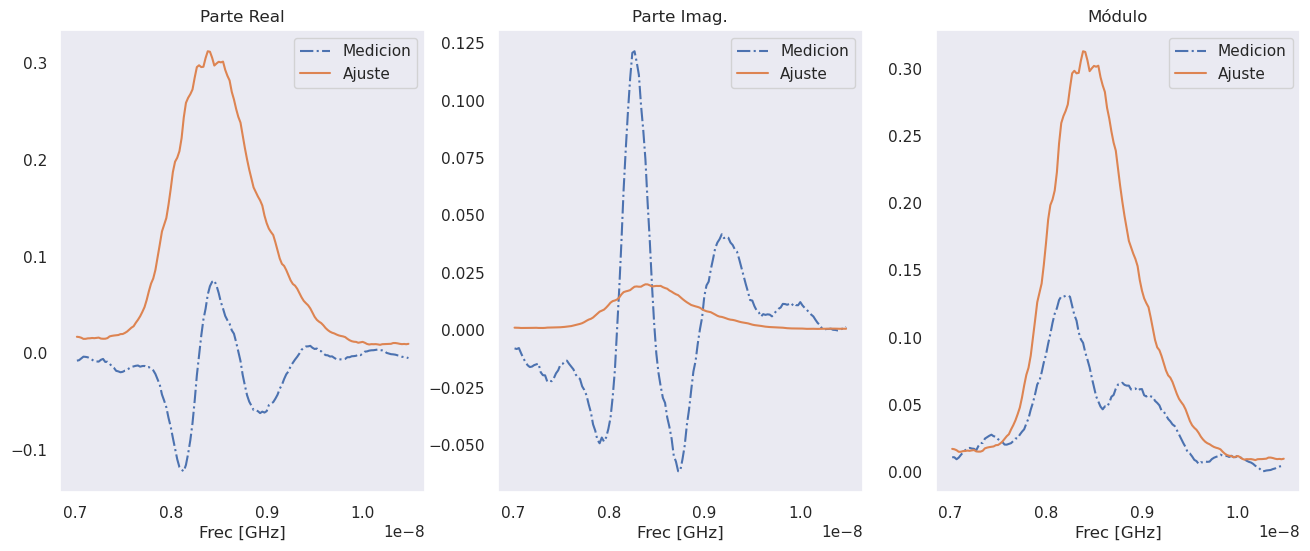

In [87]:
fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))

ax[0].plot(f_pos/1e9,np.real(Star),'-.',label="Medicion")
ax[0].plot(f_pos/1e9,np.real(S_fit),label="Ajuste")
ax[0].grid()
ax[0].set_xlabel('Frec [GHz]')
ax[0].set_title('Parte Real')
ax[0].legend(loc="best")

ax[1].plot(f_pos/1e9,np.imag(Star),'-.',label="Medicion")
ax[1].plot(f_pos/1e9,np.imag(S_fit),label="Ajuste")
ax[1].grid()
ax[1].set_xlabel('Frec [GHz]')
ax[1].set_title('Parte Imag.')
ax[1].legend(loc="best")

ax[2].plot(f_pos/1e9,np.abs(Star),'-.',label="Medicion")
ax[2].plot(f_pos/1e9,np.abs(S_fit),label="Ajuste")
ax[2].grid()
ax[2].set_xlabel('Frec [GHz]')
ax[2].set_title('Módulo')
ax[2].legend(loc="best")
plt.show()

# - Tres dieléctricos

In [88]:
NLayers = 3

if dia == '06_09':
    # junio
    d1_obs =  9e-2
    d2_obs = 13e-2
    

elif dia == '07_15':
    # julio
    d1_obs =  2e-2
    d2_obs = 7e-2

else:
    # agosto
    d1_obs = 2e-2
    d2_obs = 9e-2


## Sin rugosidad

-------------------
Incidencia en un dielectrico con 3 capas sin rugosidad
-------------------

Datos:
Dia de medicion: 07_15
angulo: 20
Altura: 0

-------------------
Corro bayes
-------------------
Ruido :  0.025
Muestras :  2500



Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.013
Stage:   1 Beta: 0.037
Stage:   2 Beta: 0.087
Stage:   3 Beta: 0.194
Stage:   4 Beta: 0.429
Stage:   5 Beta: 0.941
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.013
Stage:   1 Beta: 0.037
Stage:   2 Beta: 0.086
Stage:   3 Beta: 0.192
Stage:   4 Beta: 0.432
Stage:   5 Beta: 0.957
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.013
Stage:   1 Beta: 0.037
Stage:   2 Beta: 0.086
Stage:   3 Beta: 0.194
Stage:   4 Beta: 0.426
Stage:   5 Beta: 0.957
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.014
Stage:   1 Beta: 0.038
Stage:   2 Beta: 0.088
Stage:   3 Beta: 0.196
Stage:   4 Beta: 0.431
Stage:   5 Beta: 0.942
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.013
Stage:   1 Beta: 0.036
Stage:   2 Beta: 0.084
Stage:   3 Beta: 0.191
Stage:   4 Beta: 0.423
Stage:   5 Beta: 0.948
Stage:   6 Beta: 1.000
Stage:   0 Beta: 0.014
Stage:   1 Beta: 0.038
Stage:   2 Beta: 0.089
Stage:   3 Beta: 0.199
Stage:   4 Beta: 0.444
Stage:   5 Beta: 0.978
S

Tiempo insumido - Inf. Bayesiana: 141.31 seg (2.36 min)
Graficando para tres dieléctricos (esto puede demorar...)


input ep1_r:  8.129
output ep1_r:  18.993 +/- 1.716

input ep1_i:  3.91
output ep1_i:  4.005 +/- 1.152

input ep2_r:  10.302
output ep2_r:  20.824 +/- 4.114

input ep2_i:  5.12
output ep2_i:  6.005 +/- 1.148

input ep3_r:  11.268
output ep3_r:  23.837 +/- 0.035

input ep3_i:  5.695
output ep3_i:  4.13 +/- 0.124

input d1:  0.02
output d1:  0.025 +/- 0.009

input d2:  0.07
output d2:  0.105 +/- 0.026

Tiempo insumido - Graficos: 6.32 seg (0.11 min)

Tiempo insumido - TOTAL: 147.62 seg (2.46 min)





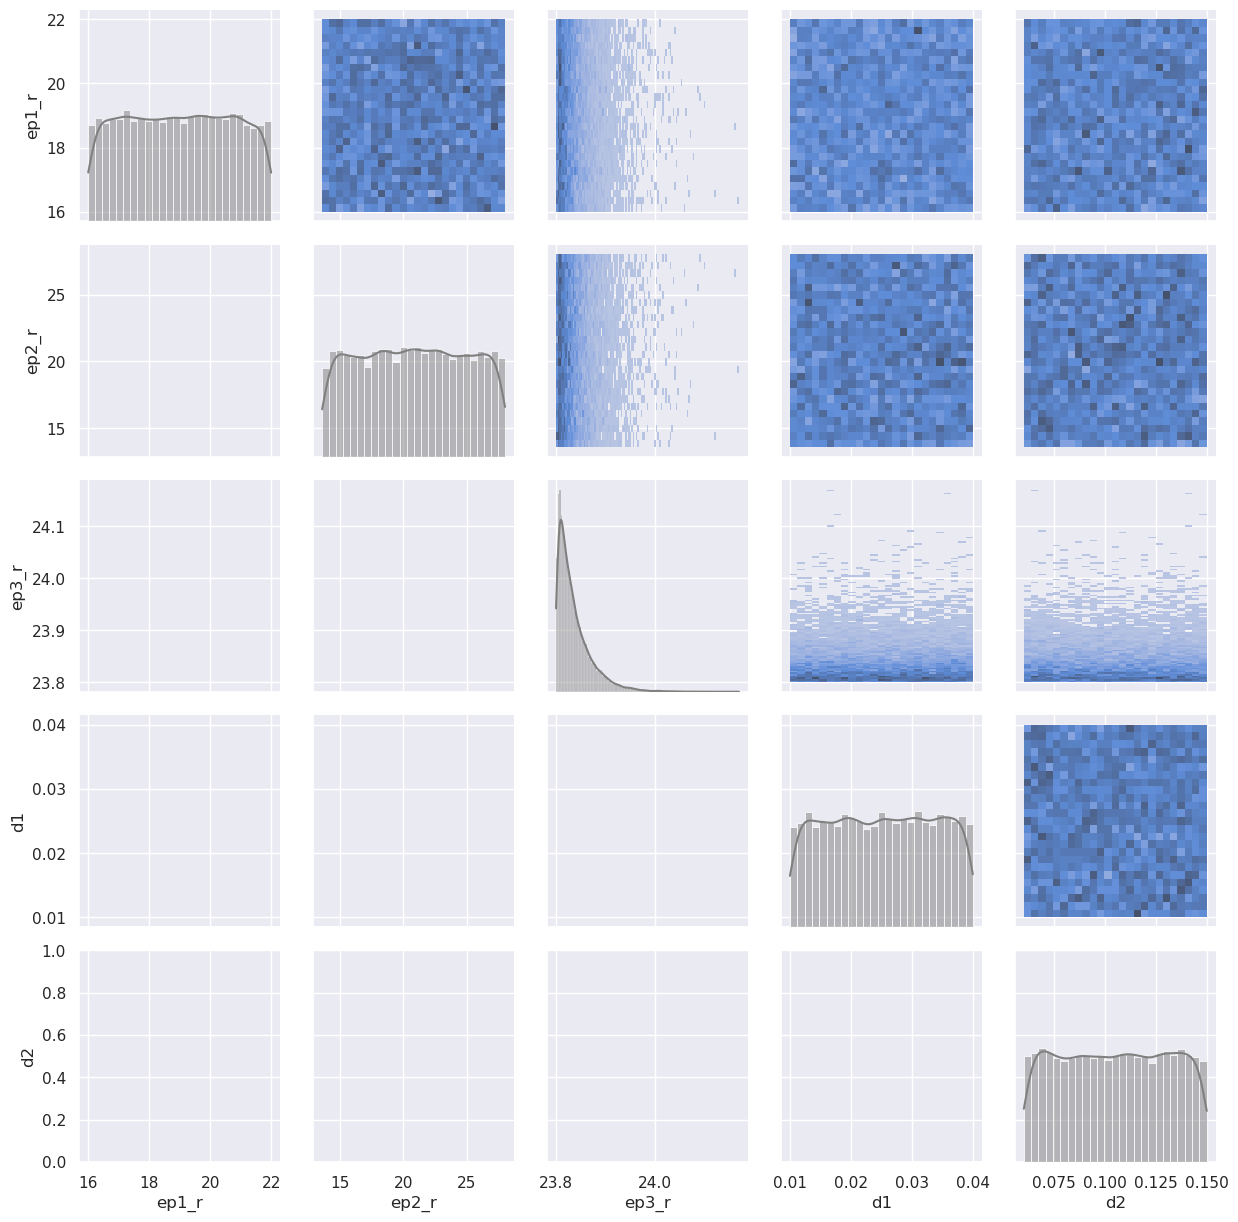

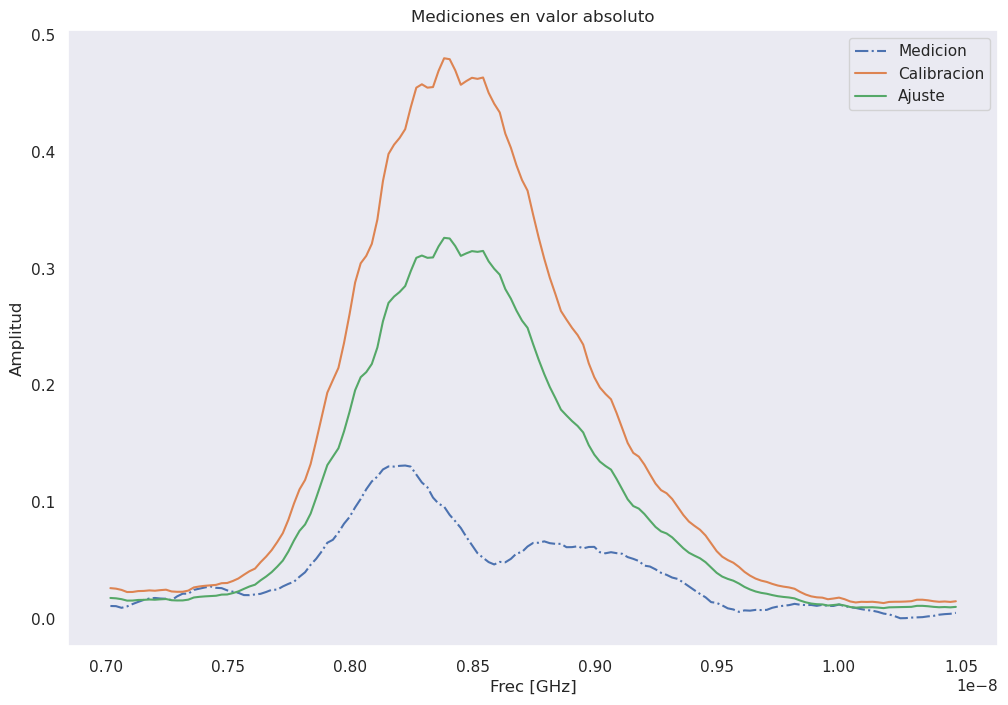

In [89]:
print('-------------------')
print('Incidencia en un dielectrico con 3 capas sin rugosidad')
print('-------------------')
print()
print('Datos:')
print('Dia de medicion:', dia)
print('angulo:', tita)
print('Altura:', altura)
name = 'lisa_'+dia+cal+'-T'+tita
print()
t0 = time.time()

print('-------------------')
print('Corro bayes')
print('-------------------')
# nro de muestras que va a utilizar el método
muestras = 2500
noise_level = 2.5e-2
# error de la medición
sigmas = noise_level*np.ones((1,len(Star)))

print('Ruido : ',noise_level)
print('Muestras : ',muestras)
print()


# inferencia bayesiana
traza_sim_3layers = modelo(Star,theta,muestras,sigmas,NLayers,rug=False)

t1 = time.time()
print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)')

#Ploteo
t2 = time.time()
print('Graficando para tres dieléctricos (esto puede demorar...)')
print()

ep1_r_mean = round(np.mean(traza_sim_3layers['ep1_r']),3)
ep1_r_std = round(np.std(traza_sim_3layers['ep1_r']),3)

ep1_i_mean = round(np.mean(traza_sim_3layers['ep1_i']),3)
ep1_i_std = round(np.std(traza_sim_3layers['ep1_i']),3)

ep2_r_mean = round(np.mean(traza_sim_3layers['ep2_r']),3)
ep2_r_std = round(np.std(traza_sim_3layers['ep2_r']),3)

ep2_i_mean = round(np.mean(traza_sim_3layers['ep2_i']),3)
ep2_i_std = round(np.std(traza_sim_3layers['ep2_i']),3)

ep3_r_mean = round(np.mean(traza_sim_3layers['ep3_r']),3)
ep3_r_std = round(np.std(traza_sim_3layers['ep3_r']),3)

ep3_i_mean = round(np.mean(traza_sim_3layers['ep3_i']),3)
ep3_i_std = round(np.std(traza_sim_3layers['ep3_i']),3)

d1_mean = round(np.mean(traza_sim_3layers['d1']),3)
d1_std = round(np.std(traza_sim_3layers['d1']),3)

d2_mean = round(np.mean(traza_sim_3layers['d2']),3)
d2_std = round(np.std(traza_sim_3layers['d2']),3)

plotear = np.stack((traza_sim_3layers['ep1_r'], traza_sim_3layers['ep2_r'], traza_sim_3layers['ep3_r'], 
                    traza_sim_3layers['d1'], traza_sim_3layers['d2'])).T 
dfplotear = pd.DataFrame(plotear, columns = ['ep1_r','ep2_r','ep3_r','d1','d2'])

g = sns.PairGrid(dfplotear)
# g.fig.suptitle(zonaMed, y=1.01, fontsize = 'xx-large')
g.map_upper(sns.histplot)
#g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True, color='.5')
g.savefig('outputs/Z2/3capas/bayes-'+name+'.png')

print()
print('input ep1_r: ', np.real(ep1_obs))
print('output ep1_r: ', str(ep1_r_mean)+" +/- "+str(ep1_r_std))
print()
print('input ep1_i: ', np.imag(ep1_obs))
print('output ep1_i: ', str(ep1_i_mean)+" +/- "+str(ep1_i_std))
print()
print('input ep2_r: ', np.real(ep2_obs))
print('output ep2_r: ', str(ep2_r_mean)+" +/- "+str(ep2_r_std))
print()
print('input ep2_i: ', np.imag(ep2_obs))
print('output ep2_i: ', str(ep2_i_mean)+" +/- "+str(ep2_i_std))
print()
print('input ep3_r: ', np.real(ep3_obs))
print('output ep3_r: ', str(ep3_r_mean)+" +/- "+str(ep3_r_std))
print()
print('input ep3_i: ', np.imag(ep3_obs))
print('output ep3_i: ', str(ep3_i_mean)+" +/- "+str(ep3_i_std))
print()
print('input d1: ', d1_obs)
print('output d1: ', str(d1_mean)+" +/- "+str(d1_std))
print()
print('input d2: ', d2_obs)
print('output d2: ', str(d2_mean)+" +/- "+str(d2_std))
print()

t3 = time.time()
print('Tiempo insumido - Graficos: '+str(round(t3-t2,2))+' seg', '('+str(round((t3-t2)/60,2))+' min)')
print()

print('Tiempo insumido - TOTAL: '+str(round(t3-t0,2))+' seg', '('+str(round((t3-t0)/60,2))+' min)')
print()
print()
print()

#---------------------------------------------
EP1 = ep1_r_mean + 1j*ep1_i_mean
EP2 = ep2_r_mean + 1j*ep2_i_mean
EP3 = ep3_r_mean + 1j*ep3_i_mean
D1 = d1_mean
D2 = d2_mean

S_fit = Scal*RR_ep1_ep2_ep3(EP1,EP2,EP3,theta,D1,D2,f_pos)

plt.figure(figsize=(12,8))
plt.plot(f_pos/1e9,np.abs(Star),'-.',label="Medicion")
plt.plot(f_pos/1e9,np.abs(Scal),label="Calibracion")
plt.plot(f_pos/1e9,np.abs(S_fit),label="Ajuste")
plt.grid()
plt.xlabel('Frec [GHz]')
plt.ylabel('Amplitud')
plt.title('Mediciones en valor absoluto')
plt.legend(loc="best")
plt.savefig('outputs/Z2/3capas/fig-'+name+'.png')
#----------------------------------------------

with open('outputs/Z2/3capas/'+name+'.txt', 'w') as f:
    print('-------------------', file=f)
    print('Incidencia en un dielectrico con 3 capas sin rugosidad', file=f)
    print('-------------------', file=f)
    print('', file=f)
    print('Datos:', file=f)
    print('Dia de medicion:', dia, file=f)
    print('angulo:', tita, file=f)
    print('Altura:', altura, file=f)
    print('', file=f)
    print('', file=f)
    print('-------------------', file=f)
    print('Corro bayes', file=f)
    print('-------------------', file=f)
    print('Ruido : ',noise_level, file=f)
    print('Muestras : ',muestras, file=f)
    print('', file=f)
    print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)', file=f)
    print('', file=f)
    print('Graficando con un solo dielectrico ...', file=f)
    print('input ep1_r: ', np.real(ep1_obs), file=f)
    print('output ep1_r: ', str(ep1_r_mean)+" +/- "+str(ep1_r_std), file=f)
    print('', file=f)
    print('input ep1_i: ', round(np.imag(ep1_obs)),3, file=f)
    print('output ep1_i: ', str(ep1_i_mean)+" +/- "+str(ep1_i_std), file=f)
    print('', file=f)
    print('input ep2_r: ', np.real(ep2_obs), file=f)
    print('output ep2_r: ', str(ep2_r_mean)+" +/- "+str(ep2_r_std), file=f)
    print('', file=f)
    print('input ep2_i: ', np.imag(ep2_obs), file=f)
    print('output ep2_i: ', str(ep2_i_mean)+" +/- "+str(ep2_i_std), file=f)
    print('', file=f)
    print('input ep3_r: ', np.real(ep3_obs), file=f)
    print('output ep3_r: ', str(ep3_r_mean)+" +/- "+str(ep3_r_std), file=f)
    print('', file=f)
    print('input ep3_i: ', np.imag(ep3_obs), file=f)
    print('output ep3_i: ', str(ep3_i_mean)+" +/- "+str(ep3_i_std), file=f)
    print('', file=f)
    print('input d1: ', d1_obs, file=f)
    print('output d1: ', str(d1_mean)+" +/- "+str(d1_std), file=f)
    print('', file=f)
    print('input d2: ', d2_obs, file=f)
    print('output d2: ', str(d2_mean)+" +/- "+str(d2_std), file=f)
    print('', file=f)
    print('Tiempo insumido - Graficos: '+str(round(t3-t2,2))+' seg', '('+str(round((t3-t2)/60,2))+' min)', file=f)
    print('Tiempo insumido - TOTAL: '+str(round(t3-t0,2))+' seg', '('+str(round((t3-t0)/60,2))+' min)', file=f)
    print('', file=f)
    print('', file=f)
f.close()

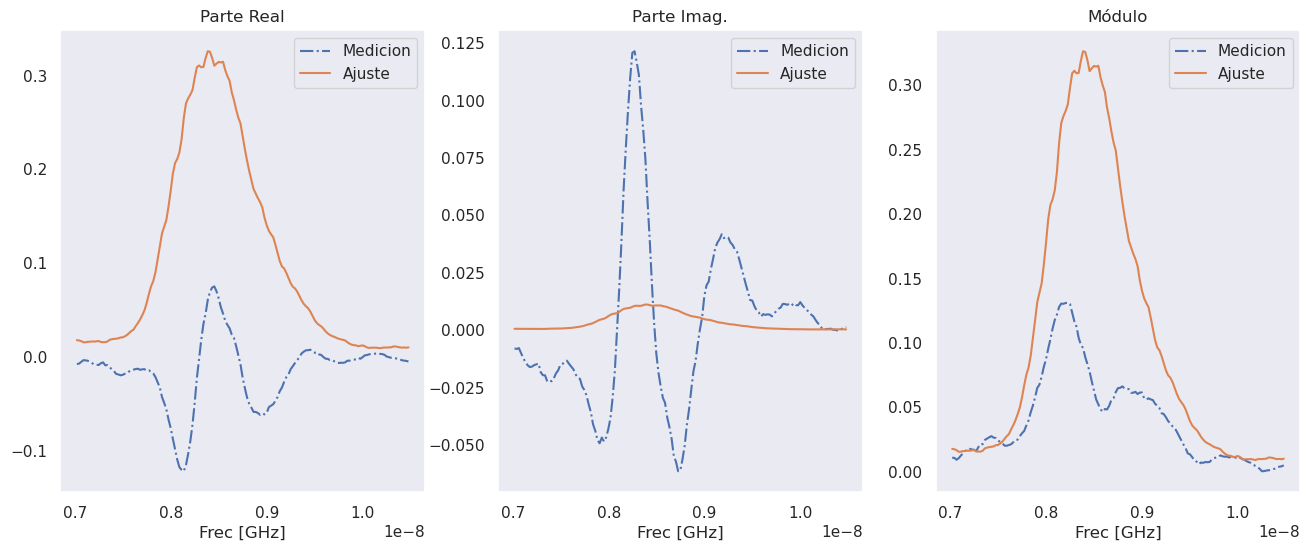

In [90]:
fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))

ax[0].plot(f_pos/1e9,np.real(Star),'-.',label="Medicion")
ax[0].plot(f_pos/1e9,np.real(S_fit),label="Ajuste")
ax[0].grid()
ax[0].set_xlabel('Frec [GHz]')
ax[0].set_title('Parte Real')
ax[0].legend(loc="best")

ax[1].plot(f_pos/1e9,np.imag(Star),'-.',label="Medicion")
ax[1].plot(f_pos/1e9,np.imag(S_fit),label="Ajuste")
ax[1].grid()
ax[1].set_xlabel('Frec [GHz]')
ax[1].set_title('Parte Imag.')
ax[1].legend(loc="best")

ax[2].plot(f_pos/1e9,np.abs(Star),'-.',label="Medicion")
ax[2].plot(f_pos/1e9,np.abs(S_fit),label="Ajuste")
ax[2].grid()
ax[2].set_xlabel('Frec [GHz]')
ax[2].set_title('Módulo')
ax[2].legend(loc="best")
plt.show()

## Con rugosidad

-------------------
Incidencia en un dielectrico con 3 capas y rugosidad
-------------------

Datos:
Dia de medicion: 07_15
angulo: 20
Altura: 0

-------------------
Corro bayes
-------------------
Ruido :  0.025
Muestras :  2500



Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.004
Stage:   1 Beta: 0.010
Stage:   2 Beta: 0.024
Stage:   3 Beta: 0.051
Stage:   4 Beta: 0.100
Stage:   5 Beta: 0.173
Stage:   6 Beta: 0.268
Stage:   7 Beta: 0.413
Stage:   8 Beta: 0.640
Stage:   9 Beta: 0.974
Stage:  10 Beta: 1.000
Stage:   0 Beta: 0.004
Stage:   1 Beta: 0.010
Stage:   2 Beta: 0.023
Stage:   3 Beta: 0.050
Stage:   4 Beta: 0.097
Stage:   5 Beta: 0.163
Stage:   6 Beta: 0.254
Stage:   7 Beta: 0.388
Stage:   8 Beta: 0.596
Stage:   9 Beta: 0.913
Stage:  10 Beta: 1.000
Stage:   0 Beta: 0.004
Stage:   1 Beta: 0.010
Stage:   2 Beta: 0.024
Stage:   3 Beta: 0.050
Stage:   4 Beta: 0.098
Stage:   5 Beta: 0.167
Stage:   6 Beta: 0.262
Stage:   7 Beta: 0.396
Stage:   8 Beta: 0.608
Stage:   9 Beta: 0.927
Stage:  10 Beta: 1.000
Stage:   0 Beta: 0.004
Stage:   1 Beta: 0.010
Stage:   2 Beta: 0.024
Stage:   3 Beta: 0.052
Stage:   4 Beta: 0.099
Stage:   5 Beta: 0.167
Stage:   6 Beta: 0.261
Stage:   7 Beta: 0.400
S

Tiempo insumido - Inf. Bayesiana: 276.46 seg (4.61 min)
Graficando para dos dieléctricos + rugosidad (esto puede demorar...)


input ep1_r:  8.129
output ep1_r:  10.064 +/- 0.681

input ep1_i:  3.91
output ep1_i:  5.943 +/- 0.059

input ep2_r:  10.302
output ep2_r:  14.011 +/- 0.011

input ep2_i:  5.12
output ep2_i:  3.024 +/- 0.023

input ep3_r:  11.268
output ep3_r:  36.318 +/- 3.282

input ep3_i:  5.695
output ep3_i:  4.984 +/- 1.388

input d1:  0.02
output d1:  0.023 +/- 0.01

input d2:  0.07
output d2:  0.174 +/- 0.043

input s0: ---
output s0:  0.001 +/- 0.000573

input s1: ---
output s1:  0.001 +/- 0.000576

input s2: ---
output s2:  0.00101 +/- 0.000576

Tiempo insumido - Graficos: 5.77 seg (0.1 min)

Tiempo insumido - TOTAL: 282.23 seg (4.7 min)





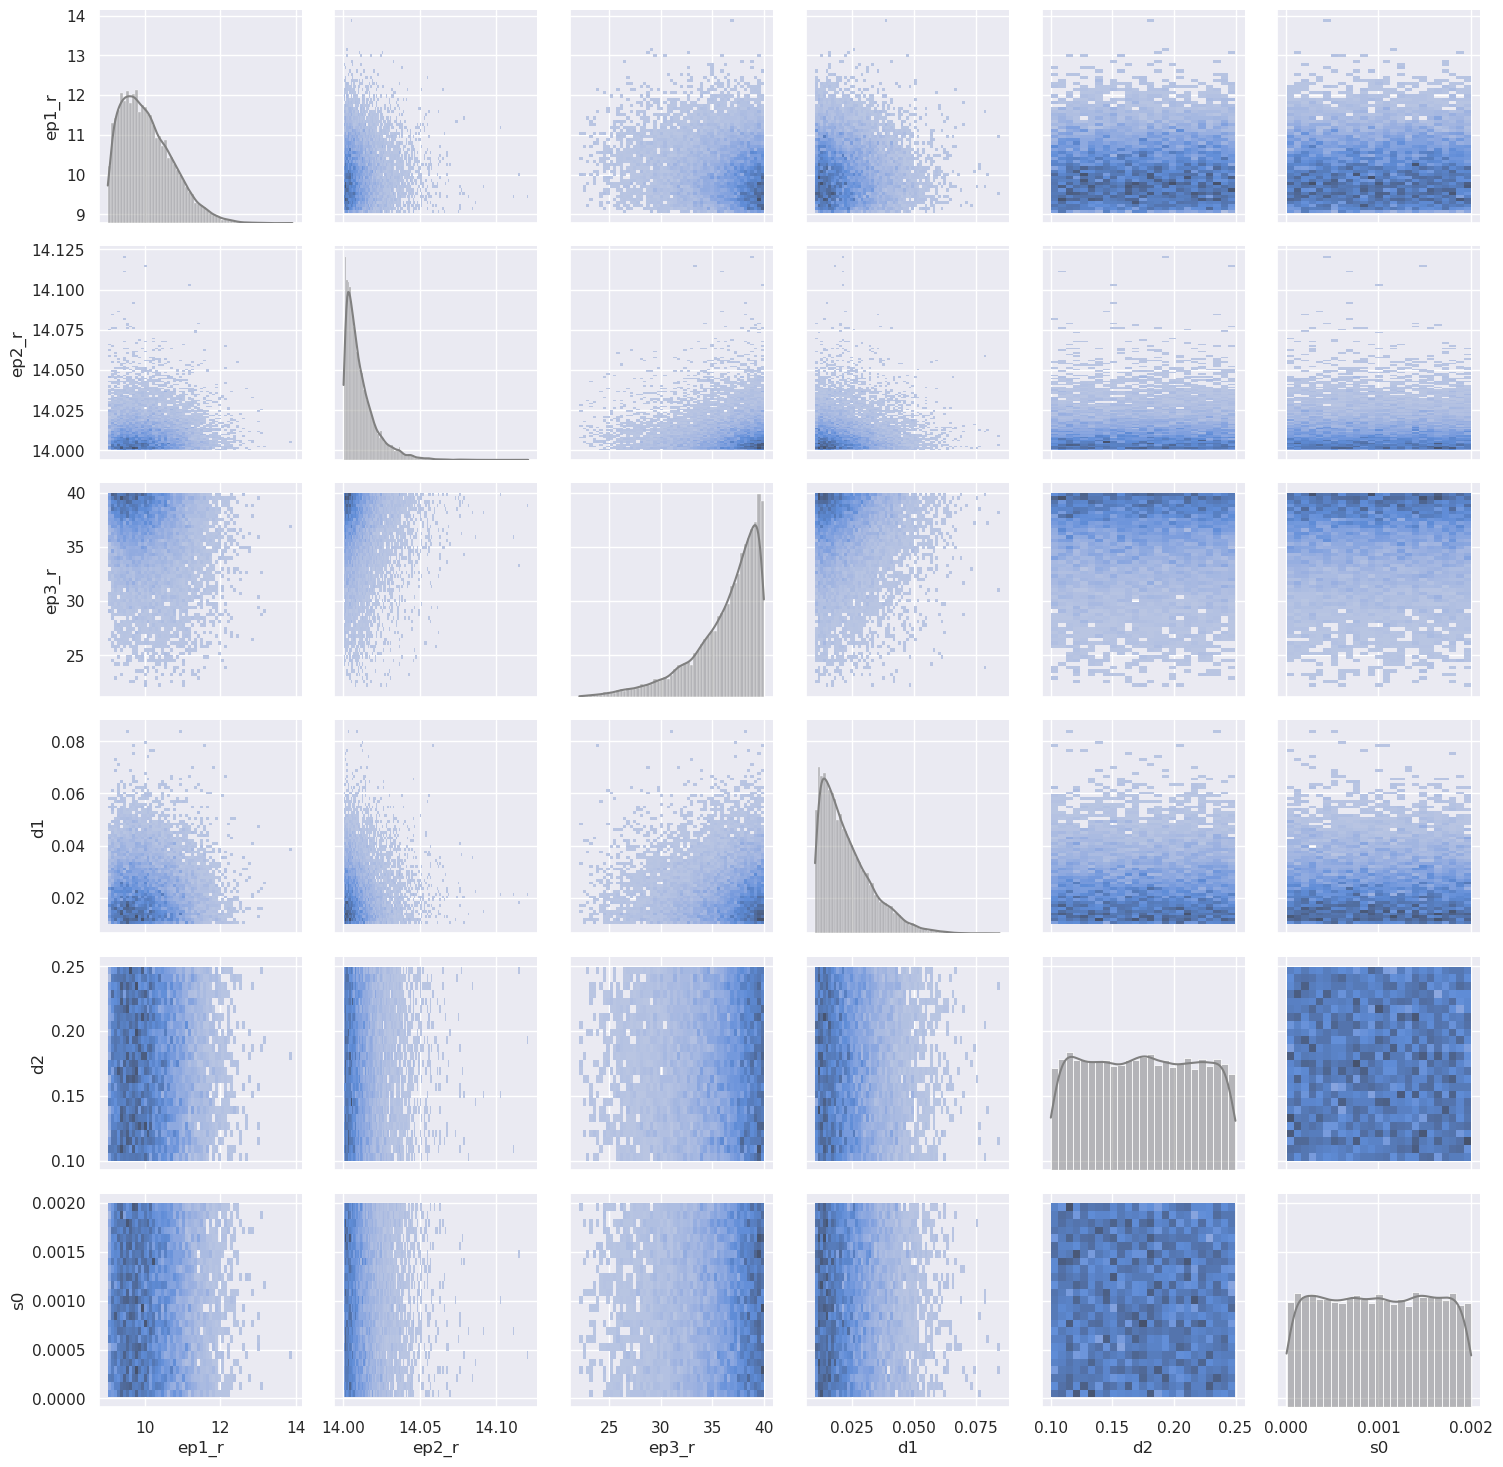

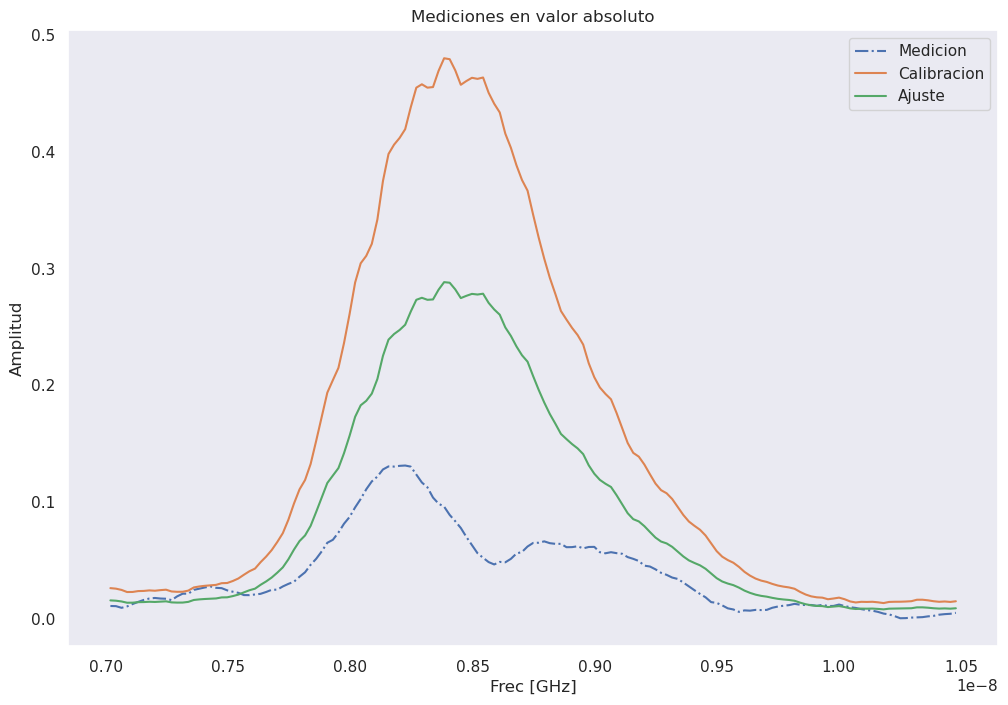

In [91]:
print('-------------------')
print('Incidencia en un dielectrico con 3 capas y rugosidad')
print('-------------------')
print()
print('Datos:')
print('Dia de medicion:', dia)
print('angulo:', tita)
print('Altura:', altura)
name = 'rug_'+dia+cal+'-T'+tita
print()
t0 = time.time()

print('-------------------')
print('Corro bayes')
print('-------------------')
# nro de muestras que va a utilizar el método
muestras = 2500
noise_level = 2.5e-2
# error de la medición
sigmas = noise_level*np.ones((2,len(Star)))

print('Ruido : ',noise_level)
print('Muestras : ',muestras)
print()


# inferencia bayesiana
traza_sim_3layers = modelo(Star,theta,muestras,sigmas,NLayers,True)

t1 = time.time()
print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)')



#Ploteo
t2 = time.time()
print('Graficando para dos dieléctricos + rugosidad (esto puede demorar...)')
print()

ep1_r_mean = round(np.mean(traza_sim_3layers['ep1_r']),3)
ep1_r_std = round(np.std(traza_sim_3layers['ep1_r']),3)

ep1_i_mean = round(np.mean(traza_sim_3layers['ep1_i']),3)
ep1_i_std = round(np.std(traza_sim_3layers['ep1_i']),3)

ep2_r_mean = round(np.mean(traza_sim_3layers['ep2_r']),3)
ep2_r_std = round(np.std(traza_sim_3layers['ep2_r']),3)

ep2_i_mean = round(np.mean(traza_sim_3layers['ep2_i']),3)
ep2_i_std = round(np.std(traza_sim_3layers['ep2_i']),3)

ep3_r_mean = round(np.mean(traza_sim_3layers['ep3_r']),3)
ep3_r_std = round(np.std(traza_sim_3layers['ep3_r']),3)

ep3_i_mean = round(np.mean(traza_sim_3layers['ep3_i']),3)
ep3_i_std = round(np.std(traza_sim_3layers['ep3_i']),3)

d1_mean = round(np.mean(traza_sim_3layers['d1']),3)
d1_std = round(np.std(traza_sim_3layers['d1']),3)

d2_mean = round(np.mean(traza_sim_3layers['d2']),3)
d2_std = round(np.std(traza_sim_3layers['d2']),3)

s0_mean = round(np.mean(traza_sim_3layers['s0']),5)
s0_std = round(np.std(traza_sim_3layers['s0']),6)

s1_mean = round(np.mean(traza_sim_3layers['s1']),5)
s1_std = round(np.std(traza_sim_3layers['s1']),6)

s2_mean = round(np.mean(traza_sim_3layers['s2']),5)
s2_std = round(np.std(traza_sim_3layers['s2']),6)

plotear = np.stack((traza_sim_3layers['ep1_r'], traza_sim_3layers['ep2_r'], traza_sim_3layers['ep3_r'],
                    traza_sim_3layers['d1'],traza_sim_3layers['d2'],traza_sim_3layers['s0'])).T 
dfplotear = pd.DataFrame(plotear, columns = ['ep1_r','ep2_r','ep3_r','d1','d2','s0'])

g = sns.PairGrid(dfplotear)
# g.fig.suptitle(zonaMed, y=1.01, fontsize = 'xx-large')
g.map_upper(sns.histplot)
g.map_lower(sns.histplot)
# g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True, color='.5')
g.savefig('outputs/Z2/3capas/bayes-'+name+'.png')

print()
print('input ep1_r: ', np.real(ep1_obs))
print('output ep1_r: ', str(ep1_r_mean)+" +/- "+str(ep1_r_std))
print()
print('input ep1_i: ', np.imag(ep1_obs))
print('output ep1_i: ', str(ep1_i_mean)+" +/- "+str(ep1_i_std))
print()
print('input ep2_r: ', np.real(ep2_obs))
print('output ep2_r: ', str(ep2_r_mean)+" +/- "+str(ep2_r_std))
print()
print('input ep2_i: ', np.imag(ep2_obs))
print('output ep2_i: ', str(ep2_i_mean)+" +/- "+str(ep2_i_std))
print()
print('input ep3_r: ', np.real(ep3_obs))
print('output ep3_r: ', str(ep3_r_mean)+" +/- "+str(ep3_r_std))
print()
print('input ep3_i: ', np.imag(ep3_obs))
print('output ep3_i: ', str(ep3_i_mean)+" +/- "+str(ep3_i_std))
print()
print('input d1: ', d1_obs)
print('output d1: ', str(d1_mean)+" +/- "+str(d1_std))
print()
print('input d2: ', d2_obs)
print('output d2: ', str(d2_mean)+" +/- "+str(d2_std))
print()
print('input s0: ---')
print('output s0: ', str(s0_mean)+" +/- "+str(s0_std))
print()
print('input s1: ---')
print('output s1: ', str(s1_mean)+" +/- "+str(s1_std))
print()
print('input s2: ---')
print('output s2: ', str(s2_mean)+" +/- "+str(s2_std))
print()


t3 = time.time()
print('Tiempo insumido - Graficos: '+str(round(t3-t2,2))+' seg', '('+str(round((t3-t2)/60,2))+' min)')
print()

print('Tiempo insumido - TOTAL: '+str(round(t3-t0,2))+' seg', '('+str(round((t3-t0)/60,2))+' min)')
print()
print()
print()


#---------------------------------------------
EP1 = ep1_r_mean + 1j*ep1_i_mean
EP2 = ep2_r_mean + 1j*ep2_i_mean
EP3 = ep3_r_mean + 1j*ep3_i_mean

D1 = d1_mean
D2 = d2_mean
S0_opt = s0_mean
S1_opt = s1_mean
S2_opt = s2_mean

S_fit = Scal*Rf_3(EP1,EP2,EP3,theta,D1,D2,S0_opt,S1_opt,S2_opt,f_pos) # señal 'medida'


plt.figure(figsize=(12,8))
plt.plot(f_pos/1e9,np.abs(Star),'-.',label="Medicion")
plt.plot(f_pos/1e9,np.abs(Scal),label="Calibracion")
plt.plot(f_pos/1e9,np.abs(S_fit),label="Ajuste")
plt.grid()
plt.xlabel('Frec [GHz]')
plt.ylabel('Amplitud')
plt.title('Mediciones en valor absoluto')
plt.legend(loc="best")
plt.savefig('outputs/Z2/3capas/fig-'+name+'.png')
#----------------------------------------------


with open('outputs/Z2/3capas/'+name+'.txt', 'w') as f:
    print('-------------------', file=f)
    print('Incidencia en un dielectrico con 3 capas y rugosidad', file=f)
    print('-------------------', file=f)
    print('', file=f)
    print('Datos:', file=f)
    print('Dia de medicion:', dia, file=f)
    print('angulo:', tita, file=f)
    print('Altura:', altura, file=f)
    print('', file=f)
    print('', file=f)

    print('-------------------', file=f)
    print('Corro bayes', file=f)
    print('-------------------', file=f)
    print('Ruido : ',noise_level, file=f)
    print('Muestras : ',muestras, file=f)
    print('', file=f)
    print('Tiempo insumido - Inf. Bayesiana: '+str(round(t1-t0,2))+' seg', '('+str(round((t1-t0)/60,2))+' min)', file=f)
    print('', file=f)

    print('Graficando con un solo dielectrico ...', file=f)
    print('input ep1_r: ', np.real(ep1_obs), file=f)
    print('output ep1_r: ', str(ep1_r_mean)+" +/- "+str(ep1_r_std), file=f)
    print('', file=f)
    print('input ep1_i: ', round(np.imag(ep1_obs)),3, file=f)
    print('output ep1_i: ', str(ep1_i_mean)+" +/- "+str(ep1_i_std), file=f)
    print('', file=f)
    print('input ep2_r: ', np.real(ep2_obs), file=f)
    print('output ep2_r: ', str(ep2_r_mean)+" +/- "+str(ep2_r_std), file=f)
    print('', file=f)
    print('input ep2_i: ', np.imag(ep2_obs), file=f)
    print('output ep2_i: ', str(ep2_i_mean)+" +/- "+str(ep2_i_std), file=f)
    print('', file=f)
    print('input ep3_i: ', np.imag(ep3_obs), file=f)
    print('output ep3_i: ', str(ep3_i_mean)+" +/- "+str(ep3_i_std), file=f)
    print('', file=f)
    print('input d1: ', d1_obs, file=f)
    print('output d1: ', str(d1_mean)+" +/- "+str(d1_std), file=f)
    print('', file=f)
    print('input d2: ', d2_obs, file=f)
    print('output d2: ', str(d2_mean)+" +/- "+str(d2_std), file=f)
    print('', file=f)
    print('input s0: ---', file=f)
    print('output s0: ', str(s0_mean)+" +/- "+str(s0_std), file=f)
    print('', file=f)
    print('input s1: ---', file=f)
    print('output s1: ', str(s1_mean)+" +/- "+str(s1_std), file=f)
    print('', file=f)
    print('input s2: ---', file=f)
    print('output s2: ', str(s2_mean)+" +/- "+str(s2_std), file=f)
    print('', file=f)
    print('Tiempo insumido - Graficos: '+str(round(t3-t2,2))+' seg', '('+str(round((t3-t2)/60,2))+' min)', file=f)
    print('Tiempo insumido - TOTAL: '+str(round(t3-t0,2))+' seg', '('+str(round((t3-t0)/60,2))+' min)', file=f)
    print('', file=f)
    print('', file=f)
f.close()

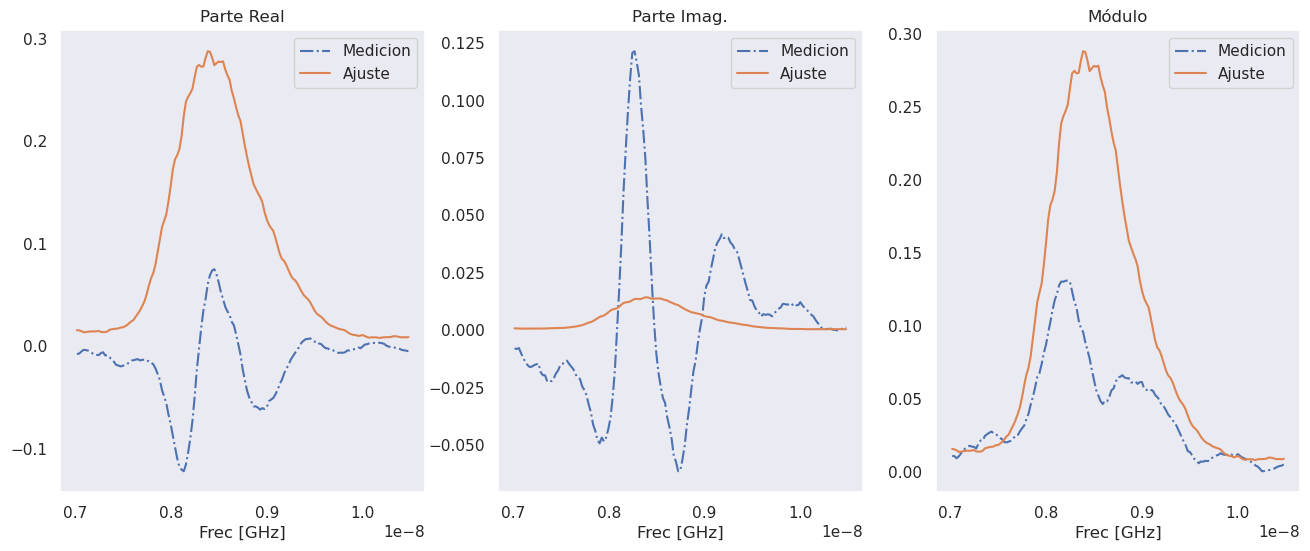

In [92]:
fig , ax = plt.subplots(nrows=1, ncols=3, figsize=(16,6))

ax[0].plot(f_pos/1e9,np.real(Star),'-.',label="Medicion")
ax[0].plot(f_pos/1e9,np.real(S_fit),label="Ajuste")
ax[0].grid()
ax[0].set_xlabel('Frec [GHz]')
ax[0].set_title('Parte Real')
ax[0].legend(loc="best")

ax[1].plot(f_pos/1e9,np.imag(Star),'-.',label="Medicion")
ax[1].plot(f_pos/1e9,np.imag(S_fit),label="Ajuste")
ax[1].grid()
ax[1].set_xlabel('Frec [GHz]')
ax[1].set_title('Parte Imag.')
ax[1].legend(loc="best")

ax[2].plot(f_pos/1e9,np.abs(Star),'-.',label="Medicion")
ax[2].plot(f_pos/1e9,np.abs(S_fit),label="Ajuste")
ax[2].grid()
ax[2].set_xlabel('Frec [GHz]')
ax[2].set_title('Módulo')
ax[2].legend(loc="best")
plt.show()